# 1. Dataset Load

## 1.1 Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tag import pos_tag
from nltk.corpus import twitter_samples
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import re, string
from nltk import FreqDist
import random
from nltk import classify
from nltk import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.mlab as mlab
from collections import Counter

from gensim.models import Word2Vec    #Import gensim Word2Vec
from sklearn.decomposition import PCA #Grab PCA functions
from sklearn.manifold import TSNE
import umap

## 1.2 Datasets

In [2]:
header_list = ["date", "location", "tweet"]

df = pd.read_csv ('trump2020-10-24.csv',header=None,names=header_list)
df_26 = pd.read_csv ('trump2020-10-26.csv',header=None,names=header_list)
df_29 = pd.read_csv ('trump2020-10-29.csv',header=None,names=header_list)

df1 = pd.read_csv('#PresidentialDebate.csv', names= header_list, header = None)
df2 = pd.read_csv('#PresidentialDebate1.csv', names= header_list, header = None)
df3 = pd.read_csv('#PresidentialDebate2.csv', names= header_list, header = None)

b1 = pd.read_csv('biden_10_23.csv', names= header_list, header = None)
b2 = pd.read_csv('biden2020-10-24.csv', names= header_list, header = None)
b3 = pd.read_csv('biden2020-10-25.csv', names= header_list, header = None)
b4 = pd.read_csv('biden2020-10-26.csv', names= header_list, header = None)
b5 = pd.read_csv('biden2020-10-27.csv', names= header_list, header = None)       
b6 = pd.read_csv('biden2020-10-28.csv', names= header_list, header = None)       
b7 = pd.read_csv('biden2020-10-29.csv', names= header_list, header = None)       
b8 = pd.read_csv('biden2020-10-30.csv', names= header_list, header = None)

df = df.append(df_26, ignore_index = True).append(df_29, ignore_index = True).\
append(df2, ignore_index = True).append(df1,ignore_index=True).append(df3, ignore_index = True).\
append(b1, ignore_index = True).append(b2, ignore_index = True).append(b3, ignore_index = True).\
append(b4, ignore_index = True).append(b5, ignore_index = True).append(b6, ignore_index = True).\
append(b7, ignore_index = True).append(b8, ignore_index = True)

df = df.dropna()


In [3]:
df['tweet'] = df['tweet'].apply(lambda x: x.split("\'")[1])
df['tweet'] = df['tweet'].apply(lambda x: re.sub('RT','',x))
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split()))
# Remove all the words that start with 'x' in tweet column
#df['tweet'] = df['tweet'].apply(lambda x: re.sub("x[a-z0-9]* ","",x))
df['tweet'] = df['tweet'].apply(lambda x: re.sub("\S*\d\S*", "", x).strip())

In [4]:
print(len(df))
df.head()

84476


,date,location,tweet
0,2020-11-06 14:17:02,b'',I wonder how would the dems react if it was th...
1,2020-11-06 14:17:02,b'',Game over Mr Trump
2,2020-11-06 14:17:02,b'',Damn Trump disgrace is gonna be monumental ...
3,2020-11-06 14:17:02,b'',These MAGA idiots who made a living being Trum...
4,2020-11-06 14:17:02,b'\xe2\x98\x85 DTX \xe2\x98\x85',Trump goin out sad They interrupted him to say...


Initial Dataset output

# 2. Sentimental Analysis Model

In [6]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]

In [7]:
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
#print(pos_tag(tweet_tokens[0]))

In [8]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

#print(lemmatize_sentence(tweet_tokens[0]))

In [9]:
def remove_noise(tweet_tokens, stop_words = ()):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        token = re.sub("rt","", token)
        token = re.sub("b","", token)
        token = re.sub("'","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['xe2', 'x80', 'xa6', 'x99s', 'xf0', 'x9f', 'x99t', 'x9d','b','donald','n','It','like','win','right','never','transition',
                'trump','rt','biden','president','election','us','pompeo','xa4','x87','x82','x8f','tweet','dtype','object','twitter',
                  'name','oject'])  

#print(remove_noise(tweet_tokens[0], stop_words))

positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []

for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

## 2.1 Determining Word Density

In [11]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token

all_pos_words = get_all_words(positive_cleaned_tokens_list)

In [12]:
freq_dist_pos = FreqDist(all_pos_words)

## 2.2 Preparing Data for the Model

In [13]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens)

positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

In [14]:
positive_dataset = [(tweet_dict, "Positive")
                     for tweet_dict in positive_tokens_for_model]

negative_dataset = [(tweet_dict, "Negative")
                     for tweet_dict in negative_tokens_for_model]

dataset = positive_dataset + negative_dataset

random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

## 2.3 Building and Testing the Model

In [78]:
classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

print(classifier.show_most_informative_features(10))

Accuracy is: 0.9963333333333333
Most Informative Features
                      :( = True           Negati : Positi =   2065.1 : 1.0
                      :) = True           Positi : Negati =   1650.8 : 1.0
                      :d = True           Positi : Negati =    292.3 : 1.0
                     #ff = True           Positi : Negati =     21.6 : 1.0
                    glad = True           Positi : Negati =     20.2 : 1.0
                  arrive = True           Positi : Negati =     18.9 : 1.0
                     sad = True           Negati : Positi =     18.0 : 1.0
                     x15 = True           Negati : Positi =     17.7 : 1.0
                    fack = True           Positi : Negati =     12.9 : 1.0
                    sick = True           Negati : Positi =     11.9 : 1.0
None


* The classifier's accuracy is 99.5% on the test data. Can be used to create a column for sentiment analysis on `trump` dataset

## 2.4 Tokenize and apply Lemmatization the `tweets`

In [15]:
nice = pd.DataFrame(df['tweet'])
nice = nice.apply(lambda x: remove_noise(word_tokenize(str(x)),stop_words),axis=1)
df['token'] = nice

## 2.5 Apply Sentiment Analysis on `presidential dataset`

In [80]:
# Apply sentimental analysis on tokenized tweets and add it as a column

lst = []
for x in nice:
    hi = classifier.classify(dict([token, True] for token in x))
    lst.append(hi)
df['sentiment'] = lst

df.head()

,date,location,tweet,token,sentiment
0,2020-11-06 14:17:02,b'',I wonder how would the dems react if it was th...,"[wonder, would, dems, react, th, ..., 0]",Negative
1,2020-11-06 14:17:02,b'',Game over Mr Trump,"[game, mr, 1]",Positive
2,2020-11-06 14:17:02,b'',Damn Trump disgrace is gonna be monumental ...,"[damn, disgrace, gon, na, e, monumental, ..., 2]",Negative
3,2020-11-06 14:17:02,b'',These MAGA idiots who made a living being Trum...,"[maga, idiot, make, living, eing, trum, ..., 3]",Positive
4,2020-11-06 14:17:02,b'\xe2\x98\x85 DTX \xe2\x98\x85',Trump goin out sad They interrupted him to say...,"[goin, sad, interrupt, say, ..., 4]",Negative


In [81]:
# Frequncy of Binary Labels in the Dataset

print(len(df[df['sentiment']=='Negative'])/len(df))
print(len(df[df['sentiment']=='Positive'])/len(df))

0.5659832378427009
0.4340167621572991


* The Output of the Dataset is fairly balanced 

# 3. Model Selection

## 3.1 TF-IDF

- TF-IDF is need to be put in as input for later models

In [33]:
tf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
txt_fitted = tf.fit(df['tweet'])
txt_transformed = txt_fitted.transform(df['tweet'])
print ('The test: ', df['tweet'])

The test:  0        I wonder how would the dems react if it was th...
1                                       Game over Mr Trump
2        Damn Trump    disgrace is gonna be monumental ...
3        These MAGA idiots who made a living being Trum...
4        Trump goin out sad They interrupted him to say...
                               ...                        
84471    Dear CNN nCan you add me to your list of peopl...
84472    Joe Biden won South Texas border counties    j...
84473    t stress enough how much the country is in a S...
84474    I appear to have hit a nerve How incredibly fl...
84475    s media could do right now to preserve democra...
Name: tweet, Length: 84476, dtype: object


## 3.2 Latent Dirichlet Allocation (LDA)

In [35]:
# Create a id2word dictionary
id2word = Dictionary(df['token'])
print(len(id2word))

# Filtering Extremes
#id2word.filter_extremes(no_below=2, no_above=.99)
#print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['token']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, workers=12, passes=5)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:20]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")
    
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['token'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


101332
------ Topic 0 ------
... keep concede presidentiald fucking world leader refusal presidentialdeate medium

------ Topic 1 ------
... ntrump lose stop deate voting idots one u fair

------ Topic 2 ------
... show would laugh even joe low lead take een

------ Topic 3 ------
... e racist least call person news today black deate

------ Topic 4 ------
... joe e get look lives plan elect call covid

------ Topic 5 ------
... aout say americans presidentialdeate reuters poll ipsos final open

------ Topic 6 ------
... joe vote elect georgia lead get take video terrence

------ Topic 7 ------
... dear add presidentialdeate joe oh cnn say think presidency

------ Topic 8 ------
... poll joe deate say bi tonight votelue pre elect

------ Topic 9 ------
... think blm antifa thug gonn people say cross camp

------ Topic 10 ------
... watch iden filthy get vote presidentialdeate deate nmodi nhate

------ Topic 11 ------
... say people camp wel joe thread presidentialdeate senior kamala

-

In [37]:
#Creating Topic Distance Visualization
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(base_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.083213 -0.064253       1        1  7.621466
6     -0.107157 -0.077727       2        1  7.108990
15    -0.011310 -0.043507       3        1  6.827217
11     0.152898 -0.154227       4        1  6.764449
1     -0.044424  0.036163       5        1  5.935399
14    -0.014987  0.047680       6        1  5.882936
3     -0.101489  0.013273       7        1  5.815675
10    -0.032808  0.020975       8        1  5.264750
19    -0.074953 -0.015197       9        1  5.247842
5      0.161612  0.083255      10        1  5.152670
2     -0.074168 -0.051750      11        1  4.658039
0     -0.001969  0.094064      12        1  4.547816
12     0.021590  0.107300      13        1  4.458639
18     0.006749 -0.012203      14        1  3.923753
16    -0.012966 -0.019153      15        1  3.750379
8      0.041692  0.002882      16        1  3.704469
9      0.106640 -0.071566      17        1  3.638045
13     0.018619  0.050148      18        1  3.634469
17    -0.000672  0.060626      19        1  3.357936
7      0.050316 -0.006782      20        1  2.705059, topic_info=         Term         Freq        Total Category  logprob  loglift
28        say  7339.000000  7339.000000  Default  30.0000  30.0000
179    people  3570.000000  3570.000000  Default  29.0000  29.0000
4766     camp  2637.000000  2637.000000  Default  28.0000  28.0000
2746      wel  2555.000000  2555.000000  Default  27.0000  27.0000
678      aout  2971.000000  2971.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
77      first    49.791570   384.739222  Topic20  -5.5980   1.5653
64       take    52.550944  1370.537321  Topic20  -5.5440   0.3489
656   preside    44.637977   375.576455  Topic20  -5.7072   1.4802
6       would    46.945588  1217.012713  Topic20  -5.6568   0.3549
678      aout    45.681631  2971.544497  Topic20  -5.6841  -0.5651

[1333 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.091188  ...
0         2  0.081239  ...
0         3  0.083149  ...
0         4  0.069136  ...
0         5  0.062870  ...
...     ...       ...  ...
2513     17  0.004298  yet
2513     18  0.008596  yet
2513     19  0.012894  yet
1578      3  0.015261  yup
1578     16  0.961434  yup

[7047 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 7, 16, 12, 2, 15, 4, 11, 20, 6, 3, 1, 13, 19, 17, 9, 10, 14, 18, 8])

In [20]:
vectorizer = CountVectorizer(stop_words='english')
data_vectorized = vectorizer.fit_transform(df['tweet'])

In [ ]:
# Can take a long time to run.
# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search to determine the best hyperparameters for lda
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             iid=True, n_jobs=1,
             param_grid={'n_topics': [5, 10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

In [ ]:
#Defining a function to loop over number of topics to be used to find an  optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic

model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df['token'],
                                                        start=2, limit=100, step=1)

# Show graph of coherence values against number of topics https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
import matplotlib.pyplot as plt
limit=100; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values_topic)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [ ]:
#Defining a function to loop over x topic to find an  optimal number for alpha
def compute_coherence_values(dictionary, corpus, texts, limit, start=0.1, step=0.1):
    """
    Compute c_v coherence for various alpha values

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max alpha value

    Returns:
    -------
    model_list : List of LDA alpha models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective alpha value
    """
    coherence_values_alpha = []
    model_list_alpha = []
    for num_alpha in numpy.arange(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=18, id2word=id2word, alpha = num_alpha )
        model_list_alpha.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_alpha.append(coherencemodel.get_coherence())

    return model_list_alpha, coherence_values_alpha

model_list_alpha, coherence_values_alpha = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df['token'],
                                                        start=0.1, limit=1, step=0.1)

# Show graph of coherence values against alpha value https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
import matplotlib.pyplot as plt
limit=1; start=0.1; step=0.1;
x = numpy.arange(start, limit, step)
plt.plot(x, coherence_values_alpha)
plt.xlabel("Alpha")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [ ]:
#Defining a function to loop over x topic and x alpha value to find an  optimal number for beta
def compute_coherence_values(dictionary, corpus, texts, limit, start=0.1, step=0.1):
    """
    Compute c_v coherence for various beta values

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max beta value

    Returns:
    -------
    model_list : List of LDA alpha models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective beta value
    """
    coherence_values_beta = []
    model_list_beta = []
    for num_beta in numpy.arange(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=18, id2word=id2word, alpha = 0.2, eta = num_beta )
        model_list_beta.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_beta.append(coherencemodel.get_coherence())

    return model_list_beta, coherence_values_beta

model_list_beta, coherence_values_beta = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=df['token'],
                                                        start=0.1, limit=1, step=0.1)

# Show graph of coherence values against alpha value https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
import matplotlib.pyplot as plt
limit=1; start=0.1; step=0.1;
x = numpy.arange(start, limit, step)
plt.plot(x, coherence_values_beta)
plt.xlabel("Beta")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
#### Final Model 
model_18 = LdaMulticore(corpus=corpus,
                       id2word=id2word,
                       num_topics=18,
                       alpha = 0.2,
                       eta = 0.5)

import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model_18, corpus, id2word)

## 3.3 BERTopic

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
data_vectorized = vectorizer.fit_transform(df['tweet'])

In [22]:
from bertopic import BERTopic
 
docs = df['tweet']

model = BERTopic("distilbert-base-nli-mean-tokens", verbose=True)

In [23]:
topics, probabilities = model.fit_transform(docs)

2020-12-01 16:48:08,010 - BERTopic - Loaded BERT model
INFO:BERTopic:Loaded BERT model
2020-12-01 17:20:23,878 - BERTopic - Transformed documents to Embeddings
INFO:BERTopic:Transformed documents to Embeddings
2020-12-01 17:25:21,217 - BERTopic - Reduced dimensionality with UMAP
INFO:BERTopic:Reduced dimensionality with UMAP
2020-12-01 21:34:09,823 - BERTopic - Clustered UMAP embeddings with HDBSCAN
INFO:BERTopic:Clustered UMAP embeddings with HDBSCAN


In [24]:
# Preview of how related each word is for specific topic

model.get_topics()

{-1: [('to', 0.02760372332996481),
  ('and', 0.026143577352185584),
  ('biden', 0.02389764035559752),
  ('trump', 0.022583652983376216),
  ('is', 0.02242570418728769),
  ('presidentialdebate', 0.02219383143767588),
  ('for', 0.020874194989730952),
  ('of', 0.020584757504582083),
  ('in', 0.02023462947998415),
  ('that', 0.019740355014660326),
  ('it', 0.018898565005436338),
  ('you', 0.018424539274153117),
  ('he', 0.018388662006065568),
  ('on', 0.01834736327607642),
  ('the', 0.016808818326736003),
  ('this', 0.015219092639472385),
  ('be', 0.015206248233598901),
  ('with', 0.014384726280168883),
  ('president', 0.014222562334463756),
  ('are', 0.014177884602288821)],
 0: [('applause', 0.33966288321413296),
  ('grace', 0.33684100318958826),
  ('moderated', 0.33091213170087713),
  ('strength', 0.32403049646576215),
  ('round', 0.2683552835149448),
  ('give', 0.2552504045115644),
  ('she', 0.2503133427229589),
  ('final', 0.18382978816015896),
  ('how', 0.17655806615943392),
  ('can', 

In [44]:
# Get frequency of topic 

model.get_topics_freq()

,Topic,Count
0,-1,32884
1,2,2513
2,497,1346
3,362,1212
4,8,1024
...,...,...
498,234,31
497,218,31
496,232,31
511,475,30


In [63]:
daniel = pd.DataFrame(model.get_topics_freq())
daniel.head()

ans = []

# Change the tuples of topic models from the top frequencies to in a list
for i in range(1,30):
    ans_temp=[]
    temp = int(daniel['Topic'][i])
    pose = model.get_topic(temp)
    for po in pose:
        ans_temp.append(po[0])
    ans.append(ans_temp)

# Make the output pallateable for the readers
for a in ans:
    print('\t')
    print('------------------------------------------')
    print('Topic New')
    print(a)
    
# Save the model for later use if necessary
model.save('ai_1')    

	
------------------------------------------
Topic New
['camps', 'joke', 'taken', 'care', 'well', 'really', 'say', 'what', 'people', 'did', 'at', 'just', 'are', 'of', 'trump', 'presidentialdebate', 'the', 'furloughs', 'funniest', 'funnier']
	
------------------------------------------
Topic New
['not', 'no', 'never', 'presidentialdebate', 'trump', 'is', 'to', 'president', 'has', 'biden', 'he', 'nothing', 'about', 'you', 'and', 'that', 'have', 'it', 'for', 'do']
	
------------------------------------------
Topic New
['it', 'not', 'he', 'you', 'biden', 'to', 're', 'that', 'don', 'is', 'be', 'embarrassment', 'know', 'no', 'get', 'want', 'have', 'do', 'and', 'about']
	
------------------------------------------
Topic New
['name', 'fucking', 'keep', 'out', 'my', 'this', 'of', 'presidentialdebate', 'mouth', 'imma', 'bernie', 'longes', 'his', 'need', 'huh', 'him', 'dumptrump', 'mask', 'seen', 'everything']
	
------------------------------------------
Topic New
['idots', 'debatenig', 'polls', 

In [22]:
# Prepare embeddings
docs = df['tweet']
sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

# Create topic model
model = BERTopic(verbose=True)

# Takes a long time to fit_transform
topics = model.fit_transform(docs, embeddings)

## 3.4 Latent Semantic Analysis (LSA)

In [21]:
n_topics = 20
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(data_vectorized)

In [22]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [23]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [24]:
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [25]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, data_vectorized, vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  presidentialdebate trump biden just did people joe say really debate
Topic 2:  biden joe georgia ntrump president votes win won wins vote
Topic 3:  coup disinformation cult speeches soundly dogs mak lawyers ss legal
Topic 4:  poll debate won voteblue bidenharristosaveamerica debatenight debatepoll tonight modera trump
Topic 5:  filthy trump nindia nsupremacy ncapitalism nhate nmodi nviolence india look
Topic 6:  essaypay onlineclasses assignmentdue assignmenthelp essaydue writerslife nwhatsapp essayhelp fucking sinking
Topic 7:  xbc xef presidentialdebate biden xbf trump xbb face today debate
Topic 8:  joe president biden elect today calls just leaders germany took
Topic 9:  think tonight nashville blm gonna tennessee wouldn pull antifa thugs
Topic 10:  president presidentialdebate biden elect trump time racist iq low latinos
Topic 11:  votes biden nbiden georgia left ntrump trump pennsylvania lead count
Topic 12:  let video terrence npresident cut stage microphone walk ndont

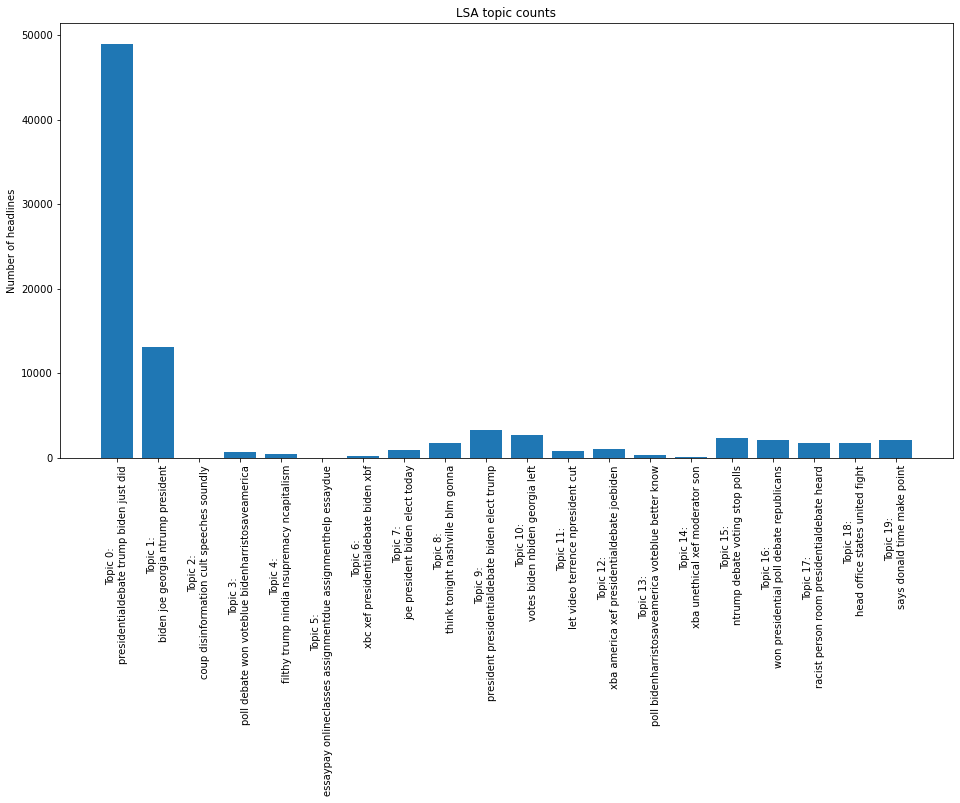

In [43]:
top_3_words = get_top_n_words(5, lsa_keys, data_vectorized, vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.xticks(rotation=90);
plt.show()

Did not perform well

## 3.5 Non-Negative Matrix Factorization (NMF)

In [34]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=20, random_state=43,  alpha=0.1, l1_ratio=0.5)
nmf_output = nmf.fit_transform(txt_transformed)

nmf_feature_names = tf.get_feature_names()
nmf_weights = nmf.components_

C:\Users\swy25\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [35]:
#####################################
## Utility functions to help with NMF
# Code adapted from Sarkar text book
#####################################

# get topics with their terms and weights
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) for row in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) for wt, index in zip(weights, sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) for row in sorted_indices])

    topics = [np.vstack((terms.T, term_weights.T)).T for terms, term_weights in zip(sorted_terms, sorted_weights)]

    return topics


# prints components of all the topics
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=False,
                     num_terms=None):

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw

# prints components of all the topics
# obtained from topic modeling
def get_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     num_terms=None):

    topic_terms = []

    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        #print(topic)
        topic = [(word, round(wt,2))
                 for word, wt in topic
                 if abs(wt) >= weight_threshold]

        topic_terms.append(topic[:num_terms] if num_terms else topic)

    return topic_terms

def getTermsAndSizes(topic_display_list_item):
    terms = []
    sizes = []
    for term, size in topic_display_list_item:
        terms.append(term)
        sizes.append(size)
    return terms, sizes

### Important terms in each Topic

In [42]:
topics = get_topics_terms_weights(nmf_weights, nmf_feature_names)
print_topics_udf(topics, total_topics=20, num_terms=10, display_weights=True)

Topic #1 with weights
[('to', 23.92), ('the', 16.15), ('and', 9.73), ('is', 6.09), ('on', 5.88), ('that', 5.84), ('going', 4.65), ('we', 4.4), ('are', 3.66), ('not', 3.64)]
Topic #2 with weights
[('filthy', 24.16), ('is', 13.52), ('nsupremacy', 4.26), ('nviolence', 4.26), ('ncapitalism', 4.26), ('nhate', 4.26), ('nmodi', 4.26), ('nindia', 4.26), ('not', 2.74), ('trump', 1.62)]
Topic #3 with weights
[('xbc', 30.39), ('nsip', 0.96), ('sniffer', 0.96), ('nlindsey', 0.95), ('chin', 0.95), ('fart', 0.94), ('shoe', 0.91), ('obese', 0.9), ('tan', 0.87), ('spray', 0.86)]
Topic #4 with weights
[('camps', 9.17), ('taken', 9.11), ('care', 9.07), ('joke', 9.06), ('well', 8.97), ('really', 8.92), ('say', 8.52), ('people', 8.42), ('what', 8.36), ('did', 8.25)]
Topic #5 with weights
[('thugs', 7.38), ('antifa', 7.38), ('tennessee', 7.37), ('pull', 7.35), ('nashville', 7.34), ('blm', 7.3), ('wouldn', 7.29), ('something', 7.19), ('or', 7.12), ('gonna', 7.09)]
Topic #6 with weights
[('off', 12.76), ('nd

Did not perform well

### 3.6 Word2Vec & PCA Visualization

In [ ]:
# Train a Word2Vec model
Word2Vecmodel = Word2Vec(df['token'], min_count=1, sg = 1)
# summarize the loaded model
print(Word2Vecmodel)

# fit a 2d PCA model to the vectors
X = Word2Vecmodel[Word2Vecmodel.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

In [ ]:
# plot the PCA output
fig, ax = plt.subplots()
ax.plot(result[:, 0], result[:, 1], 'o')
ax.set_title('Tweets')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks
plt.show()

### 3.7 t-SNE Visualization

In [ ]:
Y = TSNE(n_components=2).fit_transform(X)
#Plot the t-SNE output
fig, ax = plt.subplots()
ax.plot(Y[:, 0], Y[:, 1], 'o')
ax.set_title('Tweets')
ax.set_yticklabels([]) #Hide ticks
ax.set_xticklabels([]) #Hide ticks

# Annotate the dots with words
words = list(Word2Vecmodel.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(Y[i, 0], Y[i, 1]))
plt.show()

### 3.8 UMAP Visualization

In [ ]:
fit = umap.UMAP(n_neighbors=20, 
                min_dist=0.1, 
                n_components=2,
                metric = 'cosine')
Y = fit.fit_transform(X)

In [ ]:
# Create interactive UMAP visualizations https://gist.github.com/arnicas/e78a03ac16433664b40c8e8b3dfc23f7
import plotly.io as pio
#pio.renderers.default = 'svg'
pio.renderers.default = 'browser'
import plotly.graph_objs as go

vocabulary = set(Word2Vecmodel.wv.vocab)

def build_tooltip(row):
    full_string = ['<b>Word:</b> ', row['word']]
    return ''.join(full_string)

relevant_words = list(Word2Vecmodel.wv.vocab)

d = pd.DataFrame(Y, columns=['c1', 'c2'])
d['word'] = [w for w in relevant_words]
#d['count'] = [int(w) for w in relevant_words]
d['tooltip'] = d.apply(build_tooltip, axis=1)


trace = go.Scattergl(
    x = d['c1'],
    y = d['c2'],
    name = 'Embedding',
    mode = 'markers',

    marker = dict(
#        color = d['log_count'],
        colorscale='Viridis',
        size = 6,
        line = dict(
            width = 0.5,
        ),
        opacity=0.75
    ),
    text=d['tooltip']
)

layout = dict(title = "Word2Vec 2D UMAP Embeddings for Tweets",
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False),
              hovermode = 'closest'
             )

fig = go.Figure(data=[trace], layout=layout)
fig.show()